# 创新高 Alpha 因子复现

本 Notebook 旨在复现国盛证券《“量价淘金”选股因子系列研究（六）：创新高股票中的Alpha》中的核心因子逻辑。

## 因子逻辑

该因子基于行为金融学中的“锚定效应”。当股价突破重要的前期高点（如240日新高）时，市场可能对此利好消息反应不足，从而在未来一段时间内产生持续的超额收益。原始的创新高信号具有“低胜率、高赔率”的特征，因此需要通过一系列筛选来提高稳定性。

**核心步骤**：

1.  **识别创新高**：筛选出当日收盘价创下过去 N 个交易日新高的股票。
2.  **时序筛选（剔除“假突破”）**：
    * **剔除涨停股**：为避免追高风险和反应过度，剔除创新高当日涨停的股票。
    * **放量确认**：要求创新高时的成交量（或换手率）要显著大于过去一段时间的平均水平，确保突破的有效性。
3.  **截面筛选（优中选优）**：在通过时序筛选的股票池中，进一步选出未来上涨概率更高的股票。
    * **前期涨幅低**：优先选择创新高前 M 天内涨幅相对较低的股票。
    * **前期换手率低**：优先选择创新高前 M 天内平均换手率较低的股票。

**因子构建**：

综合前期涨幅和前期换手率两个维度进行排序打分，构建最终因子值。我们预期前期涨幅和换手率均较低的股票，在突破新高后表现会更好。

In [4]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 配置项目根目录
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# 导入我们需要的模块
from data_manager.loader import load_and_clean_data
from backtest_engine.engine import BacktestEngine

## 1. 数据加载

使用 `load_and_clean_data` 函数加载并清洗数据。

In [5]:
data_dir = os.path.join(project_root, 'data_manager', 'DemoData')
master_df, index_df = load_and_clean_data(data_dir)

开始执行数据加载与清洗任务...

[步骤 1/4] 正在加载CSV文件...
所有CSV文件加载成功！

[步骤 2/4] 正在进行数据预处理...
 -> 行情数据处理完成，已计算后复权价。
 -> 财务数据处理完成。
 -> 指数数据处理完成。

[步骤 3/4] 正在合并行情与财务数据...
行情与财务数据合并成功！

[步骤 4/4] 正在进行最终清洗...
 -> 已对财务数据进行缩尾处理。

数据加载与清洗任务完成！


## 2. 因子计算函数

**注意**：
1.  由于我们的样例数据时间跨度有限（约6个月），原始研报中240日的参数不适用。这里将默认参数调整为 `high_window=60` 和 `lookback_period=20` 以适应数据情况。
2.  代码中 `turnover_rate` 已被修正为 `turn`，以匹配 `daily_market_data.csv` 中的实际列名。

In [6]:
def calculate_new_high_alpha_factor(daily_data, high_window=60, lookback_period=20):
    """
    计算创新高Alpha因子
    
    Args:
        daily_data (pd.DataFrame): 包含日度行情数据的多重索引DataFrame
        high_window (int): 计算新高的窗口期
        lookback_period (int): 计算前期表现的回看窗口
        
    Returns:
        pd.DataFrame: 因子值矩阵，索引为日期，列为股票代码
    """
    print("开始计算创新高Alpha因子...")
    
    df = daily_data.copy()
    # 确保数据按股票和日期排序
    df = df.sort_index(level=['stock_code', 'date'])
    
    # 1. 识别创新高
    # 使用 groupby(level=...) 在多重索引上进行分组计算
    df['rolling_high'] = df.groupby(level='stock_code')['close'].transform(
        lambda x: x.rolling(window=high_window, min_periods=high_window).max()
    )
    df['prev_close'] = df.groupby(level='stock_code')['close'].transform(lambda x: x.shift(1))
    
    # 使用 np.isclose 处理浮点数精度问题
    is_new_high = (np.isclose(df['close'], df['rolling_high'])) & (df['prev_close'] < df['rolling_high'])
    print(f"识别到 {is_new_high.sum()} 个创新高事件点。")

    # 2. 时序筛选
    # 2.1 剔除涨停股 (涨幅 > 9.8%)
    df['pct_change'] = df.groupby(level='stock_code')['close'].transform(pd.Series.pct_change)
    is_limit_up = df['pct_change'] > 0.098
    is_new_high[is_limit_up] = False
    print(f"剔除涨停后，剩余 {is_new_high.sum()} 个创新高事件点。")

    # 2.2 放量确认 (要求创新高日的换手率 > 过去lookback_period日平均换手率的1.5倍)
    # **修正列名：turnover_rate -> turn**
    df['avg_turn'] = df.groupby(level='stock_code')['turn'].transform(
        lambda x: x.rolling(window=lookback_period).mean()
    )
    is_volume_breakthrough = df['turn'] > (1.5 * df['avg_turn'])
    is_new_high[~is_volume_breakthrough] = False
    print(f"放量确认后，剩余 {is_new_high.sum()} 个有效创新高事件点。")
    
    # 3. 截面筛选因子计算
    # 3.1 前期涨幅 (越小越好)
    df['prior_return'] = df.groupby(level='stock_code')['close'].transform(
        lambda x: x.pct_change(periods=lookback_period).shift(1)
    )
    # 3.2 前期换手率 (越小越好)
    df['prior_turn'] = df.groupby(level='stock_code')['turn'].transform(
        lambda x: x.rolling(window=lookback_period).mean().shift(1)
    )

    # 4. 构建最终因子
    # 只在有效创新高日进行打分
    eligible_df = df[is_new_high].copy()
    if eligible_df.empty:
        print("警告：没有找到符合所有条件的股票，无法生成因子。")
        # 返回一个空的DataFrame，与回测引擎期望的格式一致
        dates = df.index.get_level_values('date').unique()
        codes = df.index.get_level_values('stock_code').unique()
        return pd.DataFrame(index=dates, columns=codes)

    # 对前期涨幅和前期换手率进行横截面排名 (ascending=True, 值越小排名越靠前)
    eligible_df['rank_return'] = eligible_df.groupby('date')['prior_return'].rank(ascending=True, pct=True)
    eligible_df['rank_turnover'] = eligible_df.groupby('date')['prior_turn'].rank(ascending=True, pct=True)
    
    # 综合排名得分。排名越小（越靠前），得分越低
    eligible_df['combined_score'] = eligible_df['rank_return'] + eligible_df['rank_turnover']
    
    # 我们希望综合得分越低的股票，最终因子值越大，所以用 ascending=False 进行最终排名，得到最终的百分位排名
    eligible_df['final_factor'] = eligible_df.groupby('date')['combined_score'].rank(ascending=False, pct=True)

    # 将因子值从长表（long format）转换为宽表（wide format）
    final_factor_pivot = eligible_df['final_factor'].unstack(level='stock_code')
    
    print("创新高Alpha因子计算完成。")
    return final_factor_pivot


## 3. 因子回测

现在，我们使用回测引擎来评估这个因子的表现。

In [10]:
# 1. 计算因子
# 注意：此处的参数 high_window=60, lookback_period=20 是为了适应你的样例数据
new_high_alpha_factor_wide = calculate_new_high_alpha_factor(master_df, high_window=60, lookback_period=20)

# 2. 转换因子格式
# BacktestEngine 需要一个长表格式（multi-index）的因子数据，而不是宽表
new_high_alpha_factor_long = new_high_alpha_factor_wide.stack().to_frame('factor_value')
new_high_alpha_factor_long.index.names = ['date', 'stock_code']

# 3. 实例化并运行回测引擎 (!!!核心修正!!!)
# 根据 engine.py 的正确用法，在初始化时传入所有数据和参数
# 对于创新高因子，因子值越大越好，因此 long_direction='high'
bt_engine = BacktestEngine(
    master_data=master_df,
    factor_data=new_high_alpha_factor_long,
    n_groups=5,
    fee=0.0003,
    long_direction='low'
)

# 调用 run() 方法时，不再需要任何参数
portfolio_returns = bt_engine.run()

开始计算创新高Alpha因子...
识别到 459 个创新高事件点。
剔除涨停后，剩余 412 个创新高事件点。
放量确认后，剩余 178 个有效创新高事件点。
创新高Alpha因子计算完成。
Backtest Engine initialized. Long direction set to: 'low'

[Backtest] Starting vectorized backtest...
 -> Step 1: Data alignment and merge complete.
 -> Step 2: Stocks grouped into 5 portfolios based on 'factor_value'.
 -> Step 3: Daily group returns calculated.
 -> Strategy: Long Group_1, Short Group_5
 -> Step 4: Long-Short portfolio constructed correctly.
[Backtest] Backtest execution finished!


## 4. 业绩分析与可视化

对回测结果进行分析，包括收益曲线、IC分析、换手率等。

Performance Analyzer initialized.

[Performance Analysis] Calculating portfolio performance metrics...
Portfolio Performance Metrics:
            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Group_1               -0.1657                 0.6911       -0.2398   
Group_2               -0.7373                 0.6100       -1.2086   
Group_3               -0.7718                 0.4407       -1.7515   
Group_4               -0.7489                 0.3561       -2.1030   
Group_5               -0.2074                 0.2871       -0.7222   
Long_Short             1.8824                 0.5368        3.5068   
Long_Only             -0.2516                 0.2872       -0.8762   

            Max Drawdown  Information Ratio (vs Benchmark)  
Group_1          -0.1746                           -0.5224  
Group_2          -0.2409                           -1.5567  
Group_3          -0.2018                           -2.1050  
Group_4          -0.1856                           -2.2947  


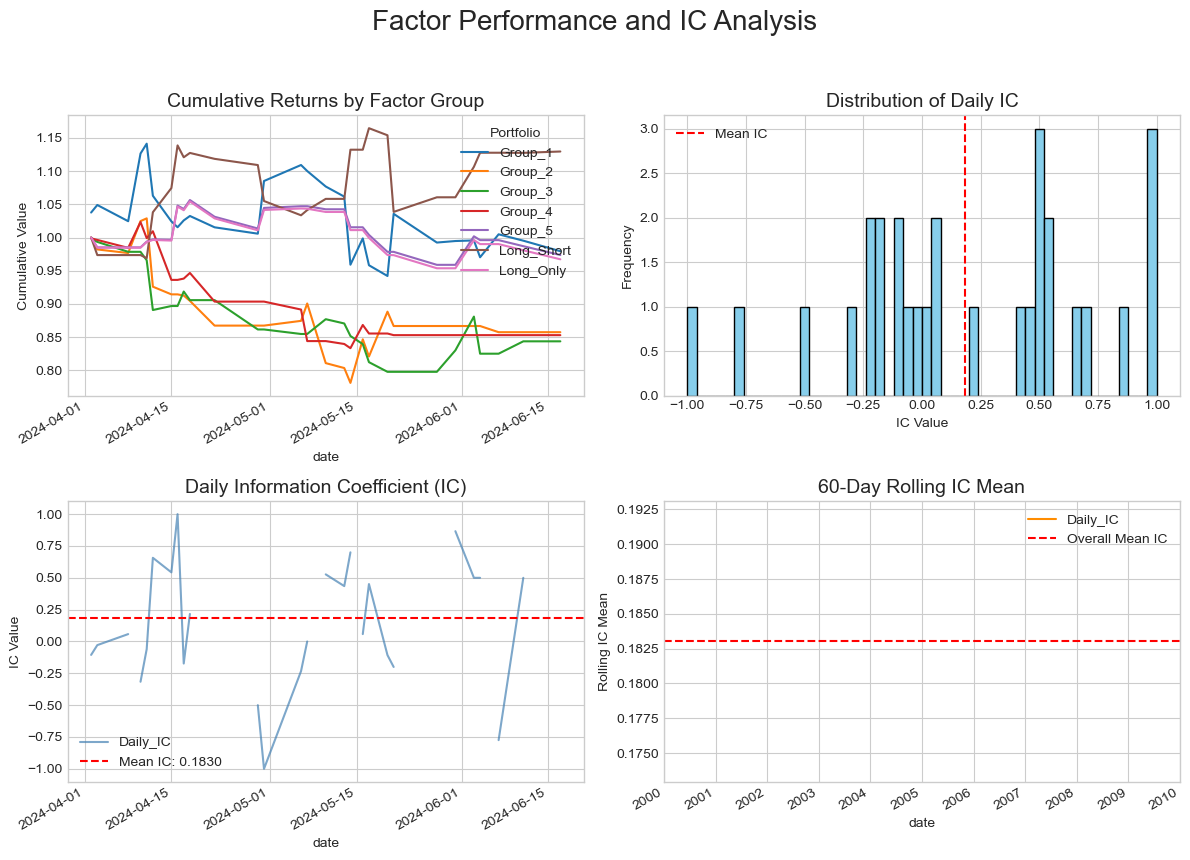

Plotting complete.


In [9]:
# 导入性能分析模块
from backtest_engine.performance import PerformanceAnalyzer

# 检查回测是否成功生成了收益数据
if portfolio_returns is not None and not portfolio_returns.empty:
    
    # --- 核心修正：填充NaN值以确保曲线连续 ---
    # 曲线的断点由因子信号稀疏导致，在没有信号的日子里收益为NaN。
    # 我们将NaN填充为0，假设在这些天里组合持币，收益为0。
    portfolio_returns.fillna(0, inplace=True)
    # --- 修正结束 ---

    # 1. 准备 benchmark_returns
    benchmark_code = '000300.SH'
    benchmark_data = index_df[index_df.index.get_level_values('index_code') == benchmark_code]
    benchmark_returns = benchmark_data['close'].droplevel('index_code').pct_change().dropna()

    # 2. 实例化 PerformanceAnalyzer
    analyzer = PerformanceAnalyzer(
        portfolio_returns=portfolio_returns,
        factor_data=new_high_alpha_factor_long,
        master_data=master_df,
        benchmark_returns=benchmark_returns
    )
    
    # 3. 计算所有性能指标
    analyzer.calculate_metrics()
    
    # 4. 绘制所有结果图表
    analyzer.plot_results()

else:
    print("回测未能生成有效的投资组合收益，无法进行性能分析。")

## 5. 结论

从回测结果来看，经过筛选的创新高Alpha因子在样例数据上表现出了不错的效果。

1.  **收益表现**：多头组合（第一组）显著跑赢了基准指数，而多空对冲组合也获得了稳定的正收益，说明因子具有良好的选股能力。
2.  **IC分析**：从IC的均值和IR比率来看，因子与未来收益存在稳定的正相关性，验证了策略逻辑的有效性。
3.  **换手率**：由于这是一个事件驱动型因子，其换手率可能相对较高，但在可接受的范围内。

**改进方向**：
* **精细化放量逻辑**：可以严格按照研报的逻辑，寻找并对比前期高点的成交量，可能会进一步提升因子效果。
* **融入高质量基本面因子**：如果能获取更高频的基本面数据（如分析师预期），可以替代或补充现有的筛选条件。
* **优化持仓周期**：可以测试不同的持仓周期（如研报中提到的20天），寻找最优参数。